# Task and Motion Planning via UP SpiderPlan

Note: this will not run in docker or on Colab since up-spiderplan requires docker. 

## Setup

Install jupyter in a python 3.7 or 3.8. For more details on up-spiderplan see https://github.com/aiplan4eu/up-spiderplan.

## Install Requirements


In [1]:
!pip install unified-planning
!pip install up-spiderplan==0.6.4

  Using cached aiddl_external_grpc-0.1.4-py3-none-any.whl (24 kB)
ERROR: Ignored the following versions that require a different python version: 0.1.1 Requires-Python >=3.8; 0.6.0.150.dev1 Requires-Python >=3.8; 0.6.0.178.dev1 Requires-Python >=3.8; 0.6.0.210.dev1 Requires-Python >=3.8; 0.6.0.212.dev1 Requires-Python >=3.8; 0.6.0.213.dev1 Requires-Python >=3.8; 0.6.0.224.dev1 Requires-Python >=3.8; 0.6.0.230.dev1 Requires-Python >=3.8; 0.6.0.235.dev1 Requires-Python >=3.8; 0.6.0.251.dev1 Requires-Python >=3.8; 0.6.0.255.dev1 Requires-Python >=3.8; 0.6.0.257.dev1 Requires-Python >=3.8; 0.6.0.259.dev1 Requires-Python >=3.8; 0.6.0.260.dev1 Requires-Python >=3.8; 0.6.0.262.dev1 Requires-Python >=3.8; 0.6.0.264.dev1 Requires-Python >=3.8; 0.6.0.268.dev1 Requires-Python >=3.8; 0.6.0.271.dev1 Requires-Python >=3.8; 0.6.0.273.dev1 Requires-Python >=3.8; 1.0.0 Requires-Python >=3.8; 1.0.0.109.dev1 Requires-Python >=3.8; 1.0.0.11.dev1 Requires-Python >=3.8; 1.0.0.112.dev1 Requires-Python >=3.8; 

In [2]:
import os
import math
import unified_planning.engines.results as results
from unified_planning.shortcuts import *
from up_spiderplan.solver import EngineImpl
from up_spiderplan.util import plot_path

# Creating Movable Robot

We declare a type for robots using the `MovableType`.

In [3]:
t_robot = MovableType("robot")

# Using a Map

Next we add an occupancy map by using a reference to a YAML file in the format used by the Robot Operating System (ROS). See http://wiki.ros.org/map_server.


In [5]:
occ_map = OccupancyMap("./maps/office-map-1.yaml", (0, 0))


# Adding Configration Types

A configuration specifies a location and orientation in our map. The last value is the number of dimensions of a configuration (here we have three for X, Y coordnates and angle).

In [6]:
t_robot_config = ConfigurationType("robot_config", occ_map, 3)

# Adding Fluents

Fluents are added as ususal, but we use our previously added `ConfigurationType` in place of a regular location.

In [7]:
t_parcel = UserType("parcel")

robot_at = Fluent("robot_at", BoolType(), robot=t_robot, configuration=t_robot_config)
parcel_at = Fluent("parcel_at", BoolType(), parcel=t_parcel, configuration=t_robot_config)
carries = Fluent("carries", BoolType(), robot=t_robot, parcel=t_parcel)

# Creating Configuraion Objects

Configuration objects combine a symbolic name like `parkin-1` with a pose. Each pose is a tuple with the number of elements specified by the configuration type (so three in this case).

In [8]:
park1 = ConfigurationObject("parking-1", t_robot_config, (46.0, 26.0, 3*math.pi/2))
park2 = ConfigurationObject("parking-2", t_robot_config, (40.0, 26.0, 3*math.pi/2))

office1 = ConfigurationObject("office-1", t_robot_config, (4.0, 4.0, 3*math.pi/2))
office2 = ConfigurationObject("office-2", t_robot_config, (14.0, 4.0, math.pi/2))
office3 = ConfigurationObject("office-3", t_robot_config, (24.0, 4.0, 3*math.pi/2))
office4 = ConfigurationObject("office-4", t_robot_config, (32.0, 4.0, 3*math.pi/2))
office5 = ConfigurationObject("office-5", t_robot_config, (4.0, 24.0, 3*math.pi/2))
office6 = ConfigurationObject("office-6", t_robot_config, (14.0, 24.0, math.pi/2))
office7 = ConfigurationObject("office-7", t_robot_config, (24.0, 24.0, math.pi/2))
office8 = ConfigurationObject("office-8", t_robot_config, (32.0, 24.0, math.pi/2))

# Adding Movable Objects

Motion planning requires objects that can move in our map. For this purpose we add two MovableObject instances for our robots names `r1` and `r2`.

The footprint specifies the 2-dimensional outline of the robot. The motion model specifies how the robot moves. Here we use the Reeds-Shepp car model (see, e.g., https://lavalle.pl/planning/ch13.pdf) which allows movement forward and backwards, and turning at a specific `turning_radius`.

In [9]:
r1 = MovableObject(
    "r1",
    t_robot,
    footprint=[(-1.0, 0.5), (1.0, 0.5), (1.0, -0.5), (-1.0, -0.5)],
    motion_model=MotionModels.REEDSSHEPP,
    parameters={"turning_radius": 2.0},
)

r2 = MovableObject(
    "r2",
    t_robot,
    footprint=[(-1.0, 0.5), (1.0, 0.5), (1.0, -0.5), (-1.0, -0.5)],
    motion_model=MotionModels.REEDSSHEPP,
    parameters={"turning_radius": 2.0},
)

# Some Additional Objects

Creating some parcels in the regular Unified Planning style.

In [10]:
nothing = Object("nothing", t_parcel)
p1 = Object("parcel-1", t_parcel)
p2 = Object("parcel-2", t_parcel)

# Operators

Now we can create operators that can use motion constraints.

## Move

The move operators has a motion constraint that requires the robot to move from its current configuration to the goal configuration. Apart from the last line that adds this constraints and the type `InstantaneousMotionAction`, this looks just like classical planning operators defined in Unified Planning.

In [11]:
move = InstantaneousMotionAction(
    "move", robot=t_robot, c_from=t_robot_config, c_to=t_robot_config
)
robot = move.parameter("robot")
c_from = move.parameter("c_from")
c_to = move.parameter("c_to")
move.add_precondition(robot_at(robot, c_from))
move.add_effect(robot_at(robot, c_from), False)
move.add_effect(robot_at(robot, c_to), True)
move.add_motion_constraint(Waypoints(robot, c_from, [c_to]))


## Pick

Robots can pick parcels at their current location if they carry nothing. This operator does not use a motion planning constraint.

In [12]:
pick = InstantaneousMotionAction(
    "pick", robot=t_robot, loc=t_robot_config, parcel=t_parcel
)
pick_robot = pick.parameter("robot")
pick_loc = pick.parameter("loc")
pick_parcel = pick.parameter("parcel")
pick.add_precondition(robot_at(pick_robot, pick_loc))
pick.add_precondition(parcel_at(pick_parcel, pick_loc))
pick.add_precondition(carries(pick_robot, nothing))
pick.add_precondition(Not(carries(pick_robot, pick_parcel)))
pick.add_effect(carries(pick_robot, pick_parcel), True)
pick.add_effect(parcel_at(pick_parcel, pick_loc), False)
pick.add_effect(carries(pick_robot, nothing), False)

## Place

Robots can place objects they carry at their current location. Again, no special motion planning constraint is used.

In [13]:
place = InstantaneousMotionAction(
    "place", robot=t_robot, loc=t_robot_config, parcel=t_parcel
)
place_robot = place.parameter("robot")
place_loc = place.parameter("loc")
place_parcel = place.parameter("parcel")
place.add_precondition(robot_at(place_robot, place_loc))
place.add_precondition(carries(place_robot, place_parcel))
place.add_precondition(Not(parcel_at(place_parcel, place_loc)))
place.add_precondition(Not(carries(place_robot, nothing)))
place.add_effect(carries(place_robot, place_parcel), False)
place.add_effect(carries(place_robot, nothing), True)
place.add_effect(parcel_at(place_parcel, place_loc), True)



Finally, we can assemble the problem. There is nothing specific to motion planning here. We use the regular UP syntax.

In [14]:
problem = Problem("TAMP")
problem.add_fluent(robot_at, default_initial_value=False)
problem.add_fluent(parcel_at, default_initial_value=False)
problem.add_fluent(carries, default_initial_value=False)
problem.add_action(move)
problem.add_action(pick)
problem.add_action(place)

problem.add_object(park1)
problem.add_object(park2)
problem.add_object(office1)
problem.add_object(office2)
problem.add_object(office3)
problem.add_object(office4)
problem.add_object(office5)
problem.add_object(office6)
problem.add_object(office7)
problem.add_object(office8)

problem.add_object(r1)
problem.add_object(r2)

problem.add_object(nothing)
problem.add_object(p1)
problem.add_object(p2)

problem.set_initial_value(carries(r1, nothing), True)
problem.set_initial_value(carries(r2, nothing), True)
problem.set_initial_value(parcel_at(p1, office1), True)
problem.set_initial_value(parcel_at(p2, office6), True)
problem.set_initial_value(robot_at(r1, park1), True)

problem.add_goal(robot_at(r1, park1))
problem.add_goal(parcel_at(p1, office2))
problem.add_goal(parcel_at(p2, office3))


# Solve the Problem and Show the Result

Now we can solve the problem and print the result. If a path exists, we plot it.

In [19]:
solver = EngineImpl(run_docker=True)
result = solver.solve(problem)

if result.status in results.POSITIVE_OUTCOMES:
    for a in result.plan.actions:
        print(a)
        print(a.motion_paths)

    
else:
    print("NO-PLAN-FOUND")


 Container up-spiderplan-server-web  Created
 Container up-spiderplan-server-web  Starting
 Container up-spiderplan-server-web  Started
 Container up-spiderplan-server-web  Stopping


move(r1, parking-1, office-6)
{waypoints(r1, parking-1, [office-6]): [((46.0, 26.0, -1.570796326794897), 0.0), ((46.0603633789135, 25.512342560663583, -1.3244845496863027), 0.0), ((46.237809778140154, 25.05412177211782, -1.0781727725777086), 0.0), ((46.521627933446595, 24.652997389447737, -0.8318609954691145), 0.0), ((46.16517403180897, 24.954701079017546, -0.5855492183605202), 0.0), ((45.72539583265515, 25.173901104571915, -0.3392374412519259), 0.0), ((45.245443620955896, 25.279254747788425, -0.09292566414333203), 0.0), ((44.754288933926354, 25.264402506781682, 0.1533861129652625), 0.0), ((44.28157952804485, 25.13024091300329, 0.3996978900738566), 0.0), ((43.85584974029457, 24.884868413574132, 0.6460096671824505), 0.0), ((43.48734316765371, 24.558283079884237, 0.7450778994020584), 0.0), ((43.12524757084194, 24.224269988914582, 0.7450778994020584), 0.0), ((42.76315197403017, 23.890256897944926, 0.7450778994020584), 0.0), ((42.4010563772184, 23.55624380697527, 0.7450778994020584), 0.0),

 Container up-spiderplan-server-web  Stopped


# Plotting the Solution

Assuming there is a solution, we can use the `plot_path` function to inspect it:

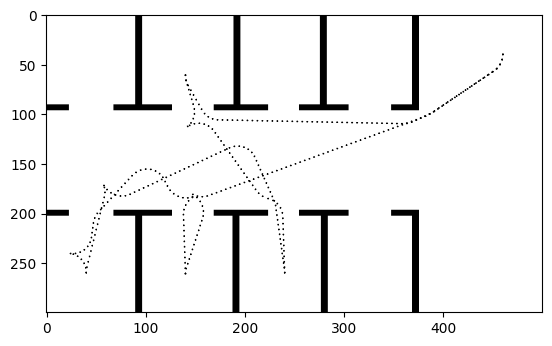

In [18]:
plot_path(result)